In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_generator, bs_call_price
from data import SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train, test

In [2]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

In [3]:
strike = 820
n_simulations = 10_000
initial_value = 818
sigma = 0.11
n_steps = 50
rf = 0
fc_dims = [32, 32, 32]
LR = 0.001
EPOCHS = 10
BATCH_SIZE = 1000
p_train = 0.9


bs_params = {"n_simulations": n_simulations,
             "n_steps": n_steps,
             "initial_value": initial_value,
             "sigma": sigma,
             }

price_params = {"n_steps": n_steps,
                "initial_value": initial_value,
                "sigma": sigma,
                "rf": rf,
                "strike": strike,
                }

payoff_params = {"strike": strike}

n_train = int(p_train * n_simulations)
n_test = n_simulations - n_train
cn = ControlNet(n_steps, 1, fc_dims, 1, learn_price=False)
optimizer = Adam(cn.parameters(), lr=LR)
#scheduler = ExponentialLR(optimizer, gamma=0.95)
criterion = torch.nn.MSELoss()

for i in range(2):
    
    dt = SimulationData(bs_generator, bs_params, bs_call_price, price_params, call_payoff, payoff_params)
    dt_train, dt_test = torch.utils.data.random_split(dt, [n_train, n_test])
    data_loader_train = DataLoader(dt_train, batch_size=BATCH_SIZE, shuffle=True)
    train(data_loader_train, cn, criterion , optimizer, EPOCHS, writer)

Epoch 0: : 0batch [00:01, ?batch/s]/root/projects/uni/fml/FML/venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([1000, 1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 0: : 9batch [00:07,  1.16batch/s, loss=452]
Epoch 1: : 9batch [00:06,  1.37batch/s, loss=252]
Epoch 2: : 9batch [00:06,  1.38batch/s, loss=138]
Epoch 3: : 9batch [00:06,  1.49batch/s, loss=75.4]
Epoch 4: : 9batch [00:06,  1.48batch/s, loss=38]
Epoch 5: : 9batch [00:05,  1.76batch/s, loss=24.4]
Epoch 6: : 9batch [00:04,  1.85batch/s, loss=16.4]
Epoch 7: : 9batch [00:04,  2.00batch/s, loss=12.8]
Epoch 8: : 9batch [00:04,  2.23batch/s, loss=12.7]
Epoch 9: : 9batch [00:04,  2.12batch/s, loss=10.1]
Epoch 0: : 9batch [00:04,  2.14batch/s, loss=8.97]
Epoch 1: : 9batch [00:04,  2.23batch/

In [4]:
# Evaluation In-Sample

model_output ,learned_price, model_loss = test(data_loader_train, cn, criterion)
print(learned_price[0], model_loss)

tensor(15.0275) tensor(4.0736, grad_fn=<MseLossBackward>)


In [5]:
x, x_inc, payoff, price = data_loader_train.dataset[:]
x_copy = torch.clone(x)
print(price)

tensor([15.0275])


In [6]:
# Comparison with delta hedging

def delta(x):
    return bs_delta(n_steps, x, sigma, rf, strike)

d_hedge = x.apply_(delta)
si = stochastic_integral(x_inc, d_hedge)
delta_loss = criterion(price + si, payoff)

print(delta_loss)

tensor(18.5505)


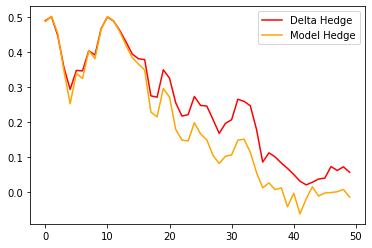

In [7]:
# Plot without underlying

plt.plot(d_hedge[0], label="Delta Hedge", c='r')
plt.plot(model_output[0].detach().numpy(), label="Model Hedge", c='orange')
plt.legend()

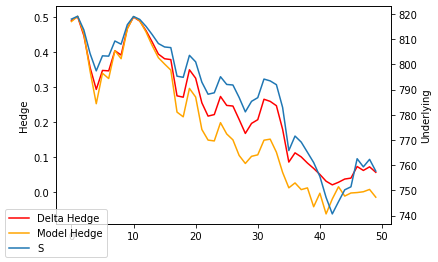

In [8]:
# Plot with underlying
fig, ax1 = plt.subplots()

ax1.set_ylabel('Hedge')
ax1.plot(d_hedge[0], label="Delta Hedge", c='r')
ax1.plot(model_output[0].detach().numpy(), label="Model Hedge", c='orange')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
ax2.set_ylabel('Underlying') 
ax2.plot(x_copy[0].squeeze(), label="S")
ax2.tick_params(axis='y')


handles, labels = ax2.get_legend_handles_labels()


lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc = 'lower left')

plt.show()


In [9]:
# Evaluation Out-of-Sample

data_loader_test = DataLoader(dt_test, batch_size=20, shuffle=True)
_ , learned_price, model_loss = test(data_loader_test, cn, criterion)

l = len(data_loader_test.dataset)
x, x_inc, payoff, price = data_loader_test.dataset[:l]

d_hedge = x.apply_(delta)
si = stochastic_integral(x_inc, d_hedge)
delta_loss = criterion(price + si, payoff)

print(model_loss)
print(delta_loss)

tensor(4.4090, grad_fn=<MseLossBackward>)
tensor(19.4370)


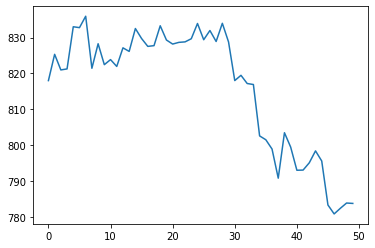

In [10]:
# Useful stuff for inspecting the model

# print gradients of first FNN's first layer

m = cn.nets[0].model
m[0].weight.grad

# Plot a training trajectory
a, b, c, d = next(iter(data_loader_train))
plt.plot(a[0])

In [11]:
# At the moment: Don't use scaling

# Important note regarding scaling: Note that BS price is homogenous wrt. stock and strike price
# i.e., C(aS, aK) = a * C(S, K)
# Is this satisfied when we move to real prices? Is it even relevant? (esp. when learning the price)

round(bs_call_price(n_steps, 100, sigma, 0, 80) - 80 * bs_call_price(n_steps, 100 / 80, sigma, 0, 1), 8)

0.0